<a href="https://colab.research.google.com/github/mhuertascompany/DL_ED127_2020/blob/master/tutorials/day5/CAE_Star_Galaxy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Unsupervised Star-Galaxy Separation with CAEs

The goal of this tutorial is to build an unsupervised star-galaxy separation using Convolutional Variational Auto-Encoders. 

We train a convolutional autoencoder (CAE) with stamps of images of stars and galaxies (without any labels). We then explore the latent space learned by the CAE and check tha the CAE has learned that there were 2 different populations in the dataset.

The dataset used for training is taken from COSMOS.

---



#### Before we start, make sure to open this Colab notebook in "PlayGround Mode" (top left) and to change the Runtime type to GPU by navigating to the toolbar and clicking Runtime -> Change runtime type and then changing Hardware accelerator to GPU

---

In [1]:
import os
import sys
import tarfile
from urllib.request import urlretrieve
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_datasets as tfds


import numpy as np
import matplotlib.pyplot as plt
import pdb
import umap

import tensorflow_probability as tfp


tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data download and preparation

Before mounting the drive click on [this folder](https://drive.google.com/drive/folders/1PcftgBzBySo1Ync-Wdsp9arTCJ_MfEPE?usp=sharing) and add it to your google drive by following these steps:

*   Go to your drive 
*   Find shared folder ("Shared with me" link)
*   Right click it
*   Click Add to My Drive



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Load data

In [0]:
pathinData="/content/drive/My Drive/EDE2019/star-galaxy"


# donwload feature vector and labels
X_ML = np.load(pathinData+'/x_train.npy')
#morphological class
Y_ML = np.load(pathinData+'/y_train.npy') 
#X_ML=X_ML-np.min(X_ML)
#print(X_ML.min())
#X_ML=X_ML/np.max(X_ML)
X_ML=(X_ML[:,30-14:30+14,30-14:30+14,:])

for i in range(len(X_ML)):
  X_ML[i,:,:]=(X_ML[i,:,:]-np.mean(X_ML[i,:,:]))/np.std(X_ML[i,:,:])

x_train=X_ML[0:int(len(X_ML)*4/5),:,:]
x_test=X_ML[int(len(X_ML)*4/5)::,:,:]

y_train=Y_ML[0:int(len(X_ML)*4/5)]
y_test=Y_ML[int(len(X_ML)*4/5)::]

### Plot some random example
Run multiple times to see more than one example. Class0 are stars, Class1 are galaxies.

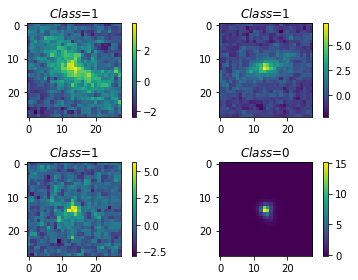

In [4]:
randomized_inds_train = np.random.permutation(len(x_train))

fig = plt.figure()
for i,j in zip(randomized_inds_train[0:4],range(4)):
  ax = fig.add_subplot(2, 2, j+1)
  im = ax.imshow(X_ML[i,:,:,0])
  plt.title('$Class$='+str(y_train[i]))
  fig.tight_layout() 
  fig.colorbar(im)

## Model Setup

The following cells set up the model in TensorFlow. We have set up a very basic Convolutional Encoder-Decoder. It does not perform super well for this problem. I encourage you to try to modify this network to achieve better results. You should in particular try to reduce more the dimension of the bottleneck (end of encoder).

In [0]:
def pack_images(images, rows, cols):
    """Helper utility to make a field of images."""
    shape = tf.shape(images)
    width = shape[-3]
    height = shape[-2]
    depth = shape[-1]
    images = tf.reshape(images, (-1, width, height, depth))
    batch = tf.shape(images)[0]
    rows = tf.minimum(rows, batch)
    cols = tf.minimum(batch // rows, cols)
    images = images[:rows * cols]
    images = tf.reshape(images, (rows, cols, width, height, depth))
    images = tf.transpose(images, [0, 2, 1, 3, 4])
    images = tf.reshape(images, [1, rows * width, cols * height, depth])
    return images


def image_tile_summary(name, tensor, rows=8, cols=8):
    tf.summary.image(name, pack_images(tensor, rows, cols), max_outputs=1)


input_shape = (28,28,1)
encoded_size = 16  # THIS IS THE SIZE OF THE BOTTLENECK --> FEEL FREE TO CHANGE
# AND EXPLORE
base_depth = 32


prior = tfd.Independent(tfd.Normal(loc=tf.zeros(encoded_size), scale=1),
                        reinterpreted_batch_ndims=1)

encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape),
    #tfkl.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
    tfkl.Conv2D(base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(4 * encoded_size, 7, strides=1,
                padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Flatten(),
    tfkl.Dense(encoded_size),
])



decoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=[encoded_size]),
    tfkl.Reshape([1, 1, encoded_size]),
    tfkl.Conv2DTranspose(2 * base_depth, 7, strides=1,
                         padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(filters=1, kernel_size=5, strides=1,
                padding='same', activation=None),
])


cae = tfk.Model(inputs=encoder.inputs,outputs=decoder(encoder.outputs[0]))




       




In [8]:
encoder.summary()
decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        25632     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          102464    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 1, 64)          200768    
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                1

## Training the model

In [0]:
#Define output path - This folder will contain the trained model
pathout='star-galaxy/models/cae1'

#Set RESET=True to delete all previous runs of the same model
RESET=False
if RESET:
  tf.summary.FileWriterCache.clear()
  os.system("rm -rf "+ pathout)

Train first for 1000 steps. This is just a trick to run TensorBoard on the notebook and follow the training.

In [10]:


cae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
            loss='mse')

hist = cae.fit(x_train,x_train,epochs=20)


Epoch 1/20
187/187 [==============================] - 2s 9ms/step - loss: 0.3882
Epoch 2/20
187/187 [==============================] - 2s 8ms/step - loss: 0.2417
Epoch 3/20
187/187 [==============================] - 2s 8ms/step - loss: 0.2375
Epoch 4/20
187/187 [==============================] - 2s 8ms/step - loss: 0.2301
Epoch 5/20
187/187 [==============================] - 2s 8ms/step - loss: 0.2265
Epoch 6/20
187/187 [==============================] - 2s 8ms/step - loss: 0.2266
Epoch 7/20
187/187 [==============================] - 2s 8ms/step - loss: 0.2313
Epoch 8/20
187/187 [==============================] - 2s 8ms/step - loss: 0.2226
Epoch 9/20
187/187 [==============================] - 2s 8ms/step - loss: 0.2214
Epoch 10/20
187/187 [==============================] - 2s 8ms/step - loss: 0.2212
Epoch 11/20
187/187 [==============================] - 2s 8ms/step - loss: 0.2217
Epoch 12/20
187/187 [==============================] - 2s 8ms/step - loss: 0.2192
Epoch 13/20
187/187 [====

## Predictions and evaluation

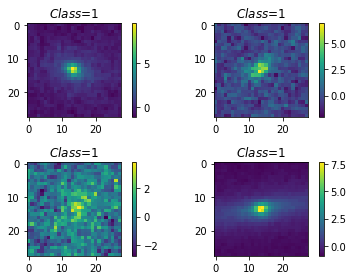

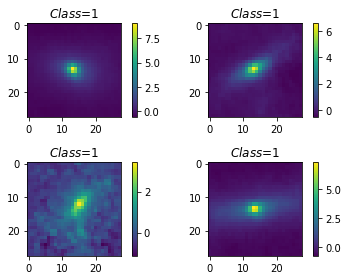

In [13]:
#predict of the first 10 examples
pred = cae(x_test[0:10])

fig = plt.figure()
for i,j in zip(range(10),range(4)):
  ax = fig.add_subplot(2, 2, j+1)
  im = ax.imshow(x_test[i,:,:,0])
  plt.title('$Class$='+str(y_test[i]))
  fig.tight_layout() 
  fig.colorbar(im)

fig = plt.figure()
for i,j in zip(range(10),range(4)):
  ax = fig.add_subplot(2, 2, j+1)
  im = ax.imshow(pred[i,:,:,0])
  plt.title('$Class$='+str(y_test[i]))
  fig.tight_layout() 
  fig.colorbar(im)

shape of encoded space: (1489, 16)


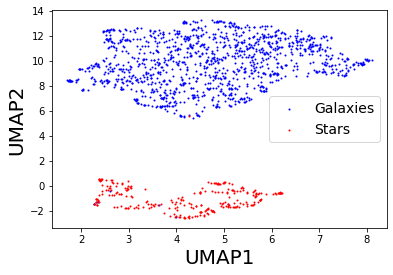

In [16]:
# Now, let's explore the latent space
z = encoder(x_test)
print("shape of encoded space:", z.shape)

# since it is 16 dimensions, we are trying to visualize it with UMAP
reducer = umap.UMAP()
embedding = reducer.fit_transform(z)
embedding.shape

xlabel("UMAP1", fontsize=20)
ylabel("UMAP2", fontsize=20)

scatter(embedding[y_test==1,1],embedding[y_test==1,0],color='blue',s=1,label='Galaxies')
scatter(embedding[y_test==0,1],embedding[y_test==0,0],color='red',s=1,label='Stars')
legend(fontsize=14)



## Clustering with GMMs





Can you run a GMM in the encoded space? Look at the scikit learn documentation for GMMs. Use it to compute a classification accuracy. What is the fraction of stars classified as galaxies with this approach. The requirement for Euclid is less than 1%... 

